### Imports + graph creation

In [1]:
import csv
from datetime import timedelta
import gurobipy as gp 
from gurobipy import GRB
import networkx as nx
import random
import matplotlib.pyplot as plt
import inspect
from collections import defaultdict

from models import simple_mpc, mpc_duration_constr, lazy, column_generation, column_generation2, column_generation3
from helper import Service, hhmm2mins, mins2hhmm, fetch_data, draw_graph_with_edges, node_legal, no_overlap, create_duty_graph, extract_nodes, generate_paths, roster_statistics, solution_verify, restricted_linear_program, generate_initial_feasible_duties_random_from_services, generate_new_column, mip


In [2]:
services, service_dict = fetch_data('./StepBackServices.csv')
graph = create_duty_graph(services)

### Main

In [ ]:
repeat =True
while repeat:
    num = int(input("""\nEnter the Model you'd like to run (integer): 
                    
                    1. Simple MPC
                    2. MPC with Duration Constraint
                    3. Lazy
                    4. Column Generation
                    
                    Expecting input: """))
    if num == 1:
        print("\nSimple MPC Model")
        duties, duty_count = simple_mpc(graph, service_dict, show_logs = False, show_duties = False, show_roster_stats = True)
        # print(duties)
        # print(duty_count)
    elif num == 2:
        print("\nMPC with Duration Constraints")
        duties, duty_count = mpc_duration_constr(graph, service_dict, time_limit = 60, show_logs = True, show_duties = False, show_roster_stats = True)
        # print(duties)
        # print(duty_count)
    elif num == 3:
        print("\nLazy Model")
        duties, duty_count = lazy(graph, service_dict, show_logs = False, max_duty_duration=6*60, lazy_iterations =100, show_lazy_updates_every = 10, show_duties = False, show_roster_stats = True)
    elif num == 4:
        print("\nColumn Generation Model")
        # duties, selected_duties, obj = column_generation(graph, service_dict, init_column_generator = "random", pricing_method = "bellman ford", iterations = 10, verbose = True)
        mpc_sol, column_pool, duties, selected_duties, obj = column_generation(graph, service_dict, init_column_generator = "mpc", mpc_timeout = 20,pricing_method = "topological sort", iterations = 10, verbose = True)
        # selected_duties -  a list of tuples (var_name, var.x)
        roster_statistics(duties.values(), service_dict)
    else:
        print("\nInvalid Input")

    repeat =False

    # repeat = input("\nWould you like to run another model? (y/n): ").lower() == 'y'



Column Generation Model
Set parameter Username
Set parameter LicenseID to value 2631367
Academic license - for non-commercial use only - expires 2026-03-05
Set parameter TimeLimit to value 20
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  20

Optimize a model with 104364 rows, 68020 columns and 335422 nonzeros
Model fingerprint: 0x4522e447
Variable types: 34478 continuous, 33542 integer (33542 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 4061 rows and 1230 columns
Presolve time: 1.82s
Presolved: 100303 rows, 66790 columns, 373298 nonzeros
Variable types: 33424 continuous, 33366 integer (33366 binary)
Found heuristic so

### Getting an integer solution from column generation fractional solution

In [4]:
sorted_duties = sorted(selected_duties, key=lambda x: x[1], reverse=True)

print(sorted_duties)

[('x136', 1.0), ('x138', 1.0), ('x141', 1.0), ('x404', 1.0), ('x465', 1.0), ('x538', 1.0), ('x886', 1.0), ('x983', 1.0), ('x38', 0.9136230375095482), ('x55', 0.9128751795168647), ('x47', 0.9030521484621596), ('x33', 0.9019169750113171), ('x11', 0.8989835791434958), ('x30', 0.8829467151098367), ('x74', 0.861153751394159), ('x108', 0.8403629989008038), ('x59', 0.8247718666344944), ('x9', 0.8051965360860671), ('x21', 0.8022754242626772), ('x127', 0.7996731508765772), ('x84', 0.792591081290141), ('x23', 0.7881051131693507), ('x1261', 0.7477537793896398), ('x5', 0.7451576462894638), ('x109', 0.743255816414312), ('x91', 0.738422836915107), ('x24', 0.735868008649773), ('x97', 0.7351135666123096), ('x29', 0.7177462948088751), ('x123', 0.7141585691652831), ('x85', 0.7136163099275661), ('x80', 0.7002442209825093), ('x6', 0.6752428445753361), ('x102', 0.6707767121014747), ('x26', 0.6635123516600725), ('x78', 0.6589598434480548), ('x51', 0.6531833880528515), ('x1271', 0.6424163953271727), ('x90', 

In [ ]:
final = []
for var_name, var_val in sorted_duties:
    #duties is a dictionary - (var_name, duty (a list of service_nums))
    final.append(duties[var_name])
    if solution_verify(service_dict.values(), final, verbose =False):
        break

print("Required duties: ", len(final))
print("Total duties: ", len(selected_duties))
roster_statistics(final, service_dict)

Required duties:  264
Total duties:  758

Roster Statistics:
Number of duties:  264
Maximum number of services in a duty:  19
Minimum number of services in a duty:  0
Maximum duration of duty:  06:00
Minimum duration of duty:  00:20
Duties with driving time more than 6hrs:  0
Duties with driving time more than 8hrs:  0


In [6]:
obj, selected_duties = mip(service_dict, column_pool, show_solutions = True, show_objective = True, warm = mpc_sol)

Set parameter TimeLimit to value 600
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600

Optimize a model with 934 rows, 2076 columns and 14210 nonzeros
Model fingerprint: 0x81ec0da3
Variable types: 0 continuous, 2076 integer (2076 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

User MIP start produced solution with objective 142 (0.01s)
Loaded user MIP start with objective 142

Presolve removed 9 rows and 312 columns
Presolve time: 0.01s
Presolved: 925 rows, 1764 columns, 13356 nonzeros
Variable types: 0 continuous, 1764 integer (1764 binary)

Root relaxation: objective 1.310450e+02, 5710 iterations, 0.93 seconds (1.45 work units)

    N

ValueError: too many values to unpack (expected 2)

In [ ]:
final_2 = []
for var_name, var_val in selected_duties:
    final_2.append(duties[var_name])
    

print("Required duties: ", len(final))
print("Total duties: ", len(selected_duties))
roster_statistics(final, service_dict)

KeyError: 'x84'

### SPPRC DP Implementation

In [19]:
import networkx as nx

# Create a directed graph (use nx.Graph() for an undirected graph)
G = nx.DiGraph()

# Add nodes with the "service_time" attribute
nodes = {
    -2 : {"service_time": 0},
    -1 : {"service_time": 0},
}
for node in range(1,6):
    nodes[node]= {"service_time" :2}

# print (nodes)

G.add_nodes_from(nodes.items())

# Add edges with the "cost" attribute
edges = [
    (1, 2, {"cost": -2}),
    (2, 3, {"cost": -5}),
    (3, 4, {"cost": -4}),
    (4, 5, {"cost": -5}),
    (1, 3, {"cost": -6})
    # (5, -1, {"cost": -4})
]

edge_dict = {
    (1, 2) : {"cost": -2},
    (2, 3) : {"cost": -5},
    (3, 4) : {"cost": -4},
    (4, 5) : {"cost": -5},
    (1, 3) : {"cost": -6}
    # (5, -1) : {"cost": -4}
}


for node in range(1,6):
    edges.append( (-2 , node, {"cost" : 0} ))
    edges.append( (node, -1, {"cost" : -4} ))

    edge_dict[(-2, node)] = {"cost" : 0}
    edge_dict[(node, -1)] = {"cost" : -4}

edges.append( (-2, -1, {"cost" : 0} ))
edge_dict[(-2, -1)] = {"cost" : 0}

G.add_edges_from(edges)

# Print all node attributes
# print("Nodes with attributes:")
# for node, attr in G.nodes(data=True):
#     print(f"{node}: {attr}")

# Print all edges with attributes
print("\nEdges with attributes:")
for u, v, attr in G.edges(data=True):
    print(f"Edge ({u} -> {v}): {attr}")

# # # Access specific attributes
# # print("\nService time at node A:", G.nodes["A"]["service_time"])
# # print("Cost of edge A -> B:", G["A"]["B"]["cost"])

# print(edge_dict)





Edges with attributes:
Edge (-2 -> 1): {'cost': 0}
Edge (-2 -> 2): {'cost': 0}
Edge (-2 -> 3): {'cost': 0}
Edge (-2 -> 4): {'cost': 0}
Edge (-2 -> 5): {'cost': 0}
Edge (-2 -> -1): {'cost': 0}
Edge (1 -> 2): {'cost': -2}
Edge (1 -> 3): {'cost': -6}
Edge (1 -> -1): {'cost': -4}
Edge (2 -> 3): {'cost': -5}
Edge (2 -> -1): {'cost': -4}
Edge (3 -> 4): {'cost': -4}
Edge (3 -> -1): {'cost': -4}
Edge (4 -> 5): {'cost': -5}
Edge (4 -> -1): {'cost': -4}
Edge (5 -> -1): {'cost': -4}


In [24]:
from collections import defaultdict
from collections import deque

dp_dict = defaultdict(dict)

topo_order = list(nx.topological_sort(G))

for time in range(7):
    dp_dict[-2][time] = (0, None)

for node in topo_order:
    for time in range(7):
        best_pred = None
        best = 0
        for pred in G.predecessors(node):
            if G.nodes[pred]["service_time"] > time:
                continue
            time_range = max(0, time - G.nodes[pred]["service_time"]) #node to pred change
            for t in range(time_range + 1):
                current = dp_dict[pred][t][0] + edge_dict [(pred, node)]["cost"]
                # print("Pred: ", pred, ", Time: ", time, ", T: ",t , "Current: ",current, "dp_dict", dp_dict[pred][t])
                if current <= best:
                    best = current
                    best_pred = pred
        dp_dict[node][time] = (best, best_pred)
    print(dp_dict)

remaining_time = 6 
current = -1
spprc = dp_dict[current][remaining_time][0]

path = deque()

while current != -2: # None to -2
    path.appendleft(current)
    # print(current, remaining_time)
    pred = dp_dict[current][remaining_time][1]
    remaining_time -= G.nodes[pred]["service_time"] #current to pred
    # remaining_time = max(0, remaining_time)
    current =pred
    # print("Shortest Path: ", path)  

print("Shortest Path Length: ", spprc)
print("Shortest Path: ", path)    
# dp_dict

defaultdict(<class 'dict'>, {-2: {0: (0, None), 1: (0, None), 2: (0, None), 3: (0, None), 4: (0, None), 5: (0, None), 6: (0, None)}})
defaultdict(<class 'dict'>, {-2: {0: (0, None), 1: (0, None), 2: (0, None), 3: (0, None), 4: (0, None), 5: (0, None), 6: (0, None)}, 1: {0: (0, -2), 1: (0, -2), 2: (0, -2), 3: (0, -2), 4: (0, -2), 5: (0, -2), 6: (0, -2)}})
defaultdict(<class 'dict'>, {-2: {0: (0, None), 1: (0, None), 2: (0, None), 3: (0, None), 4: (0, None), 5: (0, None), 6: (0, None)}, 1: {0: (0, -2), 1: (0, -2), 2: (0, -2), 3: (0, -2), 4: (0, -2), 5: (0, -2), 6: (0, -2)}, 2: {0: (0, -2), 1: (0, -2), 2: (-2, 1), 3: (-2, 1), 4: (-2, 1), 5: (-2, 1), 6: (-2, 1)}})
defaultdict(<class 'dict'>, {-2: {0: (0, None), 1: (0, None), 2: (0, None), 3: (0, None), 4: (0, None), 5: (0, None), 6: (0, None)}, 1: {0: (0, -2), 1: (0, -2), 2: (0, -2), 3: (0, -2), 4: (0, -2), 5: (0, -2), 6: (0, -2)}, 2: {0: (0, -2), 1: (0, -2), 2: (-2, 1), 3: (-2, 1), 4: (-2, 1), 5: (-2, 1), 6: (-2, 1)}, 3: {0: (0, -2), 1: (

In [73]:
for pred in G.predecessors(-2):
    print("hI")

### Column Generation using SPPRC DP

In [4]:
mpc_sol, column_pool, duties, selected_duties, obj = column_generation(graph, service_dict, init_column_generator = "mpc", mpc_timeout = 60,pricing_method = "dp", iterations = 2, verbose = True)

Set parameter TimeLimit to value 60
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 104364 rows, 68020 columns and 335422 nonzeros
Model fingerprint: 0x4522e447
Variable types: 34478 continuous, 33542 integer (33542 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 4061 rows and 1230 columns
Presolve time: 1.29s
Presolved: 100303 rows, 66790 columns, 373298 nonzeros
Variable types: 33424 continuous, 33366 integer (33366 binary)
Found heuristic solution: objective 900.0000000
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.00s

Solved 

In [3]:
mpc_sol, column_pool, duties, selected_duties, obj = column_generation(graph, service_dict, init_column_generator = "mpc", mpc_timeout = 20,pricing_method = "dp", iterations = 1, verbose = True)

Set parameter Username
Set parameter LicenseID to value 2631367
Academic license - for non-commercial use only - expires 2026-03-05
Set parameter TimeLimit to value 20
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  20

Optimize a model with 104364 rows, 68020 columns and 335422 nonzeros
Model fingerprint: 0x4522e447
Variable types: 34478 continuous, 33542 integer (33542 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 4061 rows and 1230 columns
Presolve time: 1.26s
Presolved: 100303 rows, 66790 columns, 373298 nonzeros
Variable types: 33424 continuous, 33366 integer (33366 binary)
Found heuristic solution: objective 900.000

### Column generation with IP column generator

In [ ]:
mpc_sol, column_pool, duties, selected_duties, obj = column_generation3(graph, service_dict, init_column_generator = "mpc", mpc_timeout = 30,pricing_method = "ip", iterations = 2, verbose = True)

Set parameter Username
Set parameter LicenseID to value 2631367
Academic license - for non-commercial use only - expires 2026-03-05
Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  30

Optimize a model with 104364 rows, 68020 columns and 335422 nonzeros
Model fingerprint: 0x4522e447
Variable types: 34478 continuous, 33542 integer (33542 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 4061 rows and 1230 columns
Presolve time: 1.96s
Presolved: 100303 rows, 66790 columns, 373298 nonzeros
Variable types: 33424 continuous, 33366 integer (33366 binary)
Found heuristic solution: objective 900.000

### Heuristics for column generation integer solution

In [ ]:
def cg_heuristics():
    pass

AttributeError: 'gurobipy.Var' object has no attribute 'x'

In [6]:
selected_duties

[('x0', 1.0),
 ('x1', 1.0),
 ('x2', 1.0),
 ('x3', 1.0),
 ('x4', 1.0),
 ('x5', 1.0),
 ('x6', 1.0),
 ('x7', 1.0),
 ('x8', 1.0),
 ('x9', 1.0),
 ('x10', 1.0),
 ('x11', 1.0),
 ('x12', 1.0),
 ('x13', 1.0),
 ('x14', 1.0),
 ('x15', 1.0),
 ('x16', 1.0),
 ('x17', 1.0),
 ('x18', 1.0),
 ('x19', 1.0),
 ('x20', 1.0),
 ('x21', 1.0),
 ('x22', 1.0),
 ('x23', 1.0),
 ('x24', 1.0),
 ('x25', 1.0),
 ('x26', 1.0),
 ('x27', 1.0),
 ('x28', 1.0),
 ('x29', 1.0),
 ('x30', 1.0),
 ('x31', 1.0),
 ('x32', 1.0),
 ('x33', 1.0),
 ('x34', 1.0),
 ('x35', 1.0),
 ('x36', 1.0),
 ('x37', 1.0),
 ('x38', 1.0),
 ('x39', 1.0),
 ('x40', 1.0),
 ('x41', 1.0),
 ('x42', 1.0),
 ('x43', 1.0),
 ('x44', 1.0),
 ('x45', 1.0),
 ('x46', 1.0),
 ('x47', 1.0),
 ('x48', 1.0),
 ('x49', 1.0),
 ('x50', 1.0),
 ('x51', 1.0),
 ('x52', 1.0),
 ('x53', 1.0),
 ('x54', 1.0),
 ('x55', 1.0),
 ('x56', 1.0),
 ('x57', 1.0),
 ('x58', 1.0),
 ('x59', 1.0),
 ('x60', 1.0),
 ('x61', 1.0),
 ('x62', 1.0),
 ('x63', 1.0),
 ('x64', 1.0),
 ('x65', 1.0),
 ('x66', 1.0),
 ('x6

### Plotting a graph

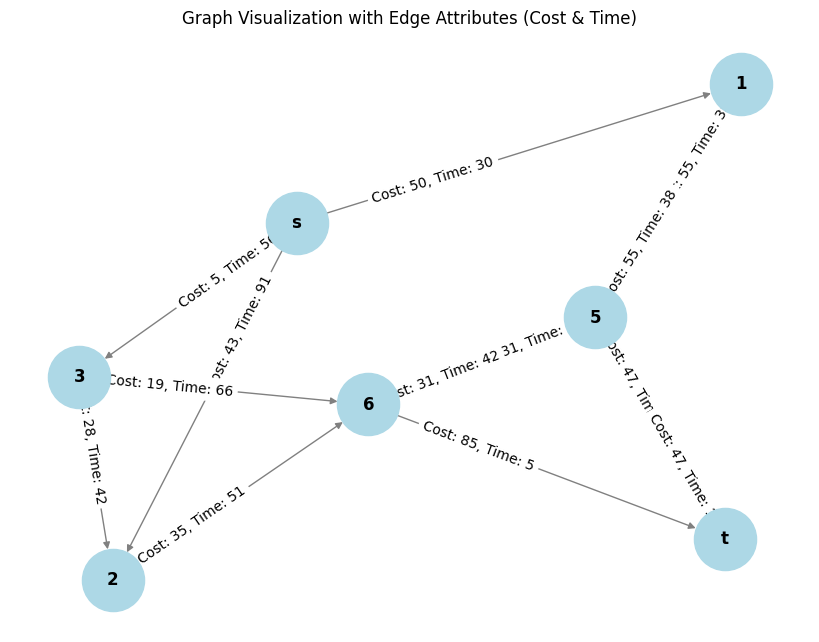

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Define edges with (node1, node2, cost, time)
edges = [
    ("s", 1 , 50 , 30),
    ("s", 2, 43, 91),
    ("s", 3, 5, 56),
    (1,5,55,38),
    (5,1,55,38),
    (2,6,35,51),
    (3,6,19,66),
    (3,2,28,42),
    (5,6,31,42),
    (6,5,31,42),
    (5,"t",47,15),
    ("t", 5, 47, 15),
    (6,"t", 85, 5)
]

# Create a directed graph
G = nx.DiGraph()

# Add edges with attributes
for u, v, cost, time in edges:
    G.add_edge(u, v, cost=cost, time=time)

# Define node positions
pos = nx.spring_layout(G, seed=42)  # Layout for visualization

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=12, font_weight='bold')

# Draw edge labels (cost and time)
edge_labels = {(u, v): f"Cost: {d['cost']}, Time: {d['time']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, label_pos=0.3)

plt.title("Graph Visualization with Edge Attributes (Cost & Time)")
plt.show()


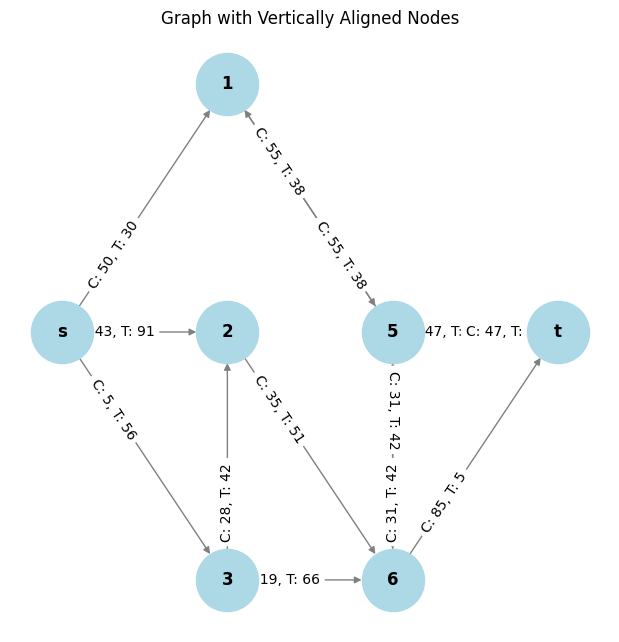

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# Define edges with (node1, node2, cost, time)
edges = [
    ("s", 1 , 50 , 30),
    ("s", 2, 43, 91),
    ("s", 3, 5, 56),
    (1,5,55,38),
    (5,1,55,38),
    (2,6,35,51),
    (3,6,19,66),
    (3,2,28,42),
    (5,6,31,42),
    (6,5,31,42),
    (5,"t",47,15),
    ("t", 5, 47, 15),
    (6,"t", 85, 5)
]

# Create a directed graph
G = nx.DiGraph()

# Add edges with attributes
for u, v, cost, time in edges:
    G.add_edge(u, v, cost=cost, time=time)

# Define node positions (3 in each column)
pos = {
    "s": (0,1),
    1: (1, 2), 2: (1, 1), 3: (1, 0),  # Left column
    5: (2, 1), 6: (2, 0),
    "t": (3,1)   # Right column
}

# Draw the graph
plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=12, font_weight='bold')

# Draw edge labels (cost and time)
edge_labels = {(u, v): f"C: {d['cost']}, T: {d['time']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, label_pos=0.3)

plt.title("Graph with Vertically Aligned Nodes")
plt.show()


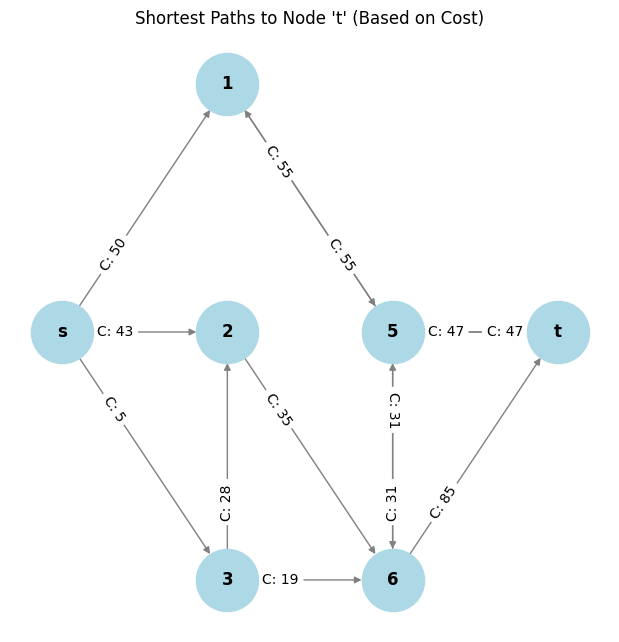

Shortest Paths to 't' with Costs:
From s → Path: ['s', 3, 6, 5, 't'], Cost: 102
From 1 → Path: [1, 5, 't'], Cost: 102
From 2 → Path: [2, 6, 5, 't'], Cost: 113
From 3 → Path: [3, 6, 5, 't'], Cost: 97
From 5 → Path: [5, 't'], Cost: 47
From 6 → Path: [6, 5, 't'], Cost: 78


In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# Define edges with (node1, node2, cost, time)
edges = [
    ("s", 1 , 50 , 30),
    ("s", 2, 43, 91),
    ("s", 3, 5, 56),
    (1,5,55,38),
    (5,1,55,38),
    (2,6,35,51),
    (3,6,19,66),
    (3,2,28,42),
    (5,6,31,42),
    (6,5,31,42),
    (5,"t",47,15),
    ("t", 5, 47, 15),
    (6,"t", 85, 5)
]

# Create a directed graph
G = nx.DiGraph()

# Add edges with attributes
for u, v, cost, time in edges:
    G.add_edge(u, v, cost=cost, time=time)

# Define node positions
pos = {
    "s": (0,1),
    1: (1, 2), 2: (1, 1), 3: (1, 0),
    5: (2, 1), 6: (2, 0),
    "t": (3,1)
}

# Compute shortest paths and their costs
shortest_paths = {}
shortest_costs = {}
shortest_edges = []

for node in G.nodes:
    if node != "t":  # Exclude target node itself
        try:
            path = nx.shortest_path(G, source=node, target="t", weight="cost")
            cost = nx.shortest_path_length(G, source=node, target="t", weight="cost")
            shortest_paths[node] = path
            shortest_costs[node] = cost
            shortest_edges.extend(list(zip(path[:-1], path[1:])))
        except nx.NetworkXNoPath:
            shortest_paths[node] = None  # No path available
            shortest_costs[node] = None  # No cost available

# Draw the graph
plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=12, font_weight='bold')

# Draw edge labels (cost)
edge_labels = {(u, v): f"C: {d['cost']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, label_pos=0.3)

# Highlight shortest paths in red
# nx.draw_networkx_edges(G, pos, edgelist=shortest_edges, edge_color='red', width=2)

plt.title("Shortest Paths to Node 't' (Based on Cost)")
plt.show()

# Print shortest paths and costs
print("Shortest Paths to 't' with Costs:")
for node in shortest_paths:
    if shortest_paths[node] is not None:
        print(f"From {node} → Path: {shortest_paths[node]}, Cost: {shortest_costs[node]}")
    else:
        print(f"From {node} → No path to 't'")


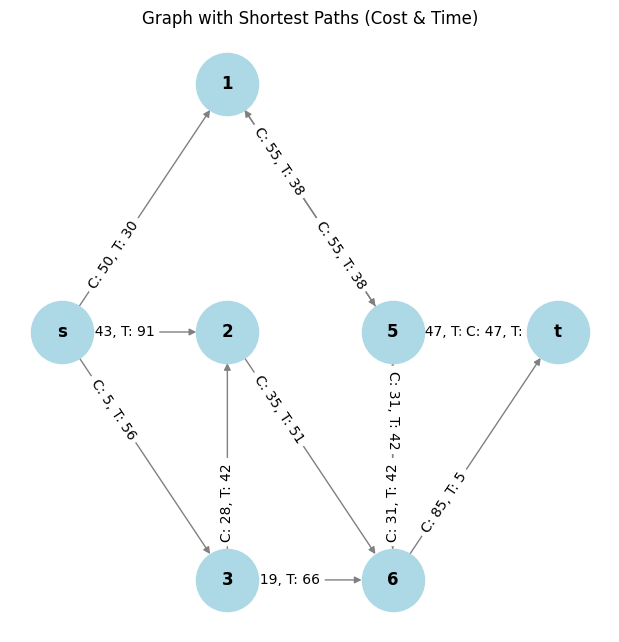


Shortest Paths from All Nodes to 't' (Using Cost):
From s → 't': Path = ['s', 3, 6, 5, 't'], Cost = 102
From 1 → 't': Path = [1, 5, 't'], Cost = 102
From 2 → 't': Path = [2, 6, 5, 't'], Cost = 113
From 3 → 't': Path = [3, 6, 5, 't'], Cost = 97
From 5 → 't': Path = [5, 't'], Cost = 47
From 6 → 't': Path = [6, 5, 't'], Cost = 78

Shortest Paths from 's' to All Nodes (Using Time):
From 's' → 1: Path = ['s', 1], Time = 30
From 's' → 2: Path = ['s', 2], Time = 91
From 's' → 3: Path = ['s', 3], Time = 56
From 's' → 5: Path = ['s', 1, 5], Time = 68
From 's' → 6: Path = ['s', 1, 5, 6], Time = 110
From 's' → t: Path = ['s', 1, 5, 't'], Time = 83

Shortest Paths from All Nodes to 't' (Using Time):
From s → 't': Path = ['s', 1, 5, 't'], Time = 83
From 1 → 't': Path = [1, 5, 't'], Time = 53
From 2 → 't': Path = [2, 6, 't'], Time = 56
From 3 → 't': Path = [3, 6, 't'], Time = 71
From 5 → 't': Path = [5, 't'], Time = 15
From 6 → 't': Path = [6, 't'], Time = 5


In [17]:
import networkx as nx
import matplotlib.pyplot as plt

# Define edges with (node1, node2, cost, time)
edges = [
    ("s", 1 , 50 , 30),
    ("s", 2, 43, 91),
    ("s", 3, 5, 56),
    (1,5,55,38),
    (5,1,55,38),
    (2,6,35,51),
    (3,6,19,66),
    (3,2,28,42),
    (5,6,31,42),
    (6,5,31,42),
    (5,"t",47,15),
    ("t", 5, 47, 15),
    (6,"t", 85, 5)
]

# Create a directed graph
G = nx.DiGraph()

# Add edges with attributes
for u, v, cost, time in edges:
    G.add_edge(u, v, cost=cost, time=time)

# Define node positions
pos = {
    "s": (0,1),
    1: (1, 2), 2: (1, 1), 3: (1, 0),
    5: (2, 1), 6: (2, 0),
    "t": (3,1)
}

# 1️⃣ Shortest paths from all nodes to "t" based on "cost"
shortest_paths_to_t_cost = {}
shortest_costs_to_t_cost = {}

for node in G.nodes:
    if node != "t":  
        try:
            path = nx.shortest_path(G, source=node, target="t", weight="cost")
            cost = nx.shortest_path_length(G, source=node, target="t", weight="cost")
            shortest_paths_to_t_cost[node] = path
            shortest_costs_to_t_cost[node] = cost
        except nx.NetworkXNoPath:
            shortest_paths_to_t_cost[node] = None
            shortest_costs_to_t_cost[node] = None

# 2️⃣ Shortest paths from "s" to all nodes based on "time"
shortest_paths_from_s_time = {}
shortest_costs_from_s_time = {}

for node in G.nodes:
    if node != "s":  
        try:
            path = nx.shortest_path(G, source="s", target=node, weight="time")
            time = nx.shortest_path_length(G, source="s", target=node, weight="time")
            shortest_paths_from_s_time[node] = path
            shortest_costs_from_s_time[node] = time
        except nx.NetworkXNoPath:
            shortest_paths_from_s_time[node] = None
            shortest_costs_from_s_time[node] = None

# 3️⃣ Shortest paths from all nodes to "t" based on "time"
shortest_paths_to_t_time = {}
shortest_costs_to_t_time = {}

for node in G.nodes:
    if node != "t":  
        try:
            path = nx.shortest_path(G, source=node, target="t", weight="time")
            time = nx.shortest_path_length(G, source=node, target="t", weight="time")
            shortest_paths_to_t_time[node] = path
            shortest_costs_to_t_time[node] = time
        except nx.NetworkXNoPath:
            shortest_paths_to_t_time[node] = None
            shortest_costs_to_t_time[node] = None

# Draw the graph
plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=12, font_weight='bold')

# Draw edge labels (cost and time)
edge_labels = {(u, v): f"C: {d['cost']}, T: {d['time']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, label_pos=0.3)

plt.title("Graph with Shortest Paths (Cost & Time)")
plt.show()

# Print shortest paths to "t" based on cost
print("\nShortest Paths from All Nodes to 't' (Using Cost):")
for node in shortest_paths_to_t_cost:
    if shortest_paths_to_t_cost[node] is not None:
        print(f"From {node} → 't': Path = {shortest_paths_to_t_cost[node]}, Cost = {shortest_costs_to_t_cost[node]}")
    else:
        print(f"From {node} → 't': No path available")

# Print shortest paths from "s" based on time
print("\nShortest Paths from 's' to All Nodes (Using Time):")
for node in shortest_paths_from_s_time:
    if shortest_paths_from_s_time[node] is not None:
        print(f"From 's' → {node}: Path = {shortest_paths_from_s_time[node]}, Time = {shortest_costs_from_s_time[node]}")
    else:
        print(f"From 's' → {node}: No path available")

# Print shortest paths to "t" based on time
print("\nShortest Paths from All Nodes to 't' (Using Time):")
for node in shortest_paths_to_t_time:
    if shortest_paths_to_t_time[node] is not None:
        print(f"From {node} → 't': Path = {shortest_paths_to_t_time[node]}, Time = {shortest_costs_to_t_time[node]}")
    else:
        print(f"From {node} → 't': No path available")
